In [1]:
import tensorboard
import tensorflow as tf
import keras 
import tensorflow_hub as hub
import tensorflow_text
import pandas as pd

In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import numpy as np

In [3]:
data = pd.read_csv('./Data/Dynasent/train.csv')

In [18]:
from sklearn.preprocessing import LabelBinarizer
encoderNew = LabelBinarizer()
transfomed_label = encoderNew.fit_transform(data['gold_label'])
data['gold_label'] = transfomed_label

# Save the encoder classes for later use
np.save('./Models/encoder.npy', encoderNew.classes_)

In [5]:
# data preprocessing
data['sentence'] = data['sentence'].apply(lambda x: x.lower())
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\n', ' '))
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\t', ' '))
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\r', ' '))
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\xa0', ' '))
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\u200b', ' '))
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\ufeff', ' '))

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((data['sentence'], data['gold_label']))

In [7]:
val_ds = pd.read_csv('./Data/Dynasent/valid.csv')

In [8]:
val_ds['sentence'] = val_ds['sentence'].apply(lambda x: x.lower())
val_ds['sentence'] = val_ds['sentence'].apply(lambda x: x.replace('\n', ' '))
val_ds['sentence'] = val_ds['sentence'].apply(lambda x: x.replace('\t', ' '))
val_ds['sentence'] = val_ds['sentence'].apply(lambda x: x.replace('\r', ' '))
val_ds['sentence'] = val_ds['sentence'].apply(lambda x: x.replace('\xa0', ' '))
val_ds['sentence'] = val_ds['sentence'].apply(lambda x: x.replace('\u200b', ' '))
val_ds['sentence'] = val_ds['sentence'].apply(lambda x: x.replace('\ufeff', ' '))

In [9]:
val_ds_label = encoder.transform(val_ds['gold_label'])
val_ds['gold_label'] = val_ds_label

val_ds = tf.data.Dataset.from_tensor_slices((val_ds['sentence'], val_ds['gold_label']))

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

train_ds = train_ds.shuffle(buffer_size=len(data)).batch(batch_size)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.shuffle(buffer_size=len(val_ds)).batch(batch_size)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
tfhub_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
tfhub_prepocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"


In [12]:
# create the deep learning model to classify text into three categories
text_input = keras.Input(shape=(), dtype='string', name='text_input')
preprocessing_layer = hub.KerasLayer(tfhub_prepocess, name='Preprocessing_for_BERT')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_encoder, trainable=False, name='BERT_encoder')
outputs = encoder(encoder_inputs)
x = keras.layers.Dropout(0.2)(outputs['sequence_output'])
x = keras.layers.Dense(50, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(25, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(20, activation='relu')(x)
x = keras.layers.Dropout(0.35)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(3, activation='softmax')(x)
model = keras.Model(inputs=[text_input], outputs=x)
model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',             
                metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 Preprocessing_for_BERT (KerasL  {'input_word_ids':   0          ['text_input[0][0]']             
 ayer)                          (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [13]:
from tensorflow.keras.callbacks import TensorBoard
import time

# logs about the training process
# accuracy and loss are plotted in the TensorBoard
log_dir = "logs/fit/" + str(int(time.time()))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [14]:
epochs = 50
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[
                        keras.callbacks.TensorBoard("logs/fit/" + str(int(time.time())),
                                                    histogram_freq=1,
                                                    write_graph=True,
                                                    write_images=True),
                        keras.callbacks.EarlyStopping(patience=5,
                                                      monitor='val_loss')

                    ])


Epoch 1/50
2516/2516 [==============================] - 983s 387ms/step - loss: 0.3569 - accuracy: 0.8458 - val_loss: 0.5513 - val_accuracy: 0.7381
Epoch 2/50
2516/2516 [==============================] - 982s 390ms/step - loss: 0.3265 - accuracy: 0.8598 - val_loss: 0.5400 - val_accuracy: 0.7400
Epoch 3/50
2516/2516 [==============================] - 955s 379ms/step - loss: 0.3135 - accuracy: 0.8666 - val_loss: 0.5160 - val_accuracy: 0.7514
Epoch 4/50
2516/2516 [==============================] - 947s 376ms/step - loss: 0.3036 - accuracy: 0.8705 - val_loss: 0.5234 - val_accuracy: 0.7483
Epoch 5/50
2516/2516 [==============================] - 971s 386ms/step - loss: 0.2931 - accuracy: 0.8749 - val_loss: 0.5088 - val_accuracy: 0.7497
Epoch 6/50
2516/2516 [==============================] - 967s 384ms/step - loss: 0.2847 - accuracy: 0.8785 - val_loss: 0.5092 - val_accuracy: 0.7544
Epoch 7/50
2516/2516 [==============================] - 960s 381ms/step - loss: 0.2765 - accuracy: 0.8827 - val_

In [15]:
# load test data
test_ds = pd.read_csv('./Data/Dynasent/test.csv')


test_ds['sentence'] = test_ds['sentence'].apply(lambda x: x.lower())
test_ds['sentence'] = test_ds['sentence'].apply(lambda x: x.replace('\n', ' '))
test_ds['sentence'] = test_ds['sentence'].apply(lambda x: x.replace('\t', ' '))
test_ds['sentence'] = test_ds['sentence'].apply(lambda x: x.replace('\r', ' '))
test_ds['sentence'] = test_ds['sentence'].apply(lambda x: x.replace('\xa0', ' '))
test_ds['sentence'] = test_ds['sentence'].apply(lambda x: x.replace('\u200b', ' '))
test_ds['sentence'] = test_ds['sentence'].apply(lambda x: x.replace('\ufeff', ' '))

In [19]:
# transform the test data using the same encoder
test_ds_label = encoderNew.transform(test_ds['gold_label'])
test_ds['gold_label'] = test_ds_label

# create the test dataset
test_ds = tf.data.Dataset.from_tensor_slices((test_ds['sentence'], test_ds['gold_label']))

In [20]:
# create the test dataset
test_ds = test_ds.shuffle(buffer_size=len(test_ds)).batch(batch_size)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


# evaluate the model
results = model.evaluate(test_ds, verbose=1, callbacks=[
    keras.callbacks.TensorBoard(log_dir='./logs',
                                histogram_freq=1,
                                write_graph=True,
                                write_images=True)]
)


# print the results
print('Test loss:', results[0])
print('Test accuracy:', results[1])

113/113 [==============================] - 40s 352ms/step - loss: 0.3527 - accuracy: 0.8747
Test loss: 0.35270124673843384
Test accuracy: 0.8747222423553467


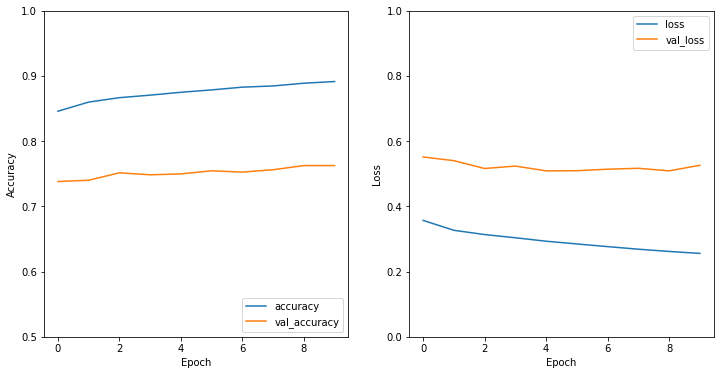

In [21]:
#draw the accuracy and loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.ylim([0, 1])
plt.show()



In [ ]:
# Test Model with Sample Test Data
text = 'There were members who do not contribute for the projects. Actually I do not prefer to work with a team'


# get prdiction from the model
prediction = model.predict([text])

In [ ]:
encoder.inverse_transform(prediction)

In [ ]:
model.save('model.pb')

In [ ]:
#save the model
model.save('./Models/model1')

In [ ]:
# load the model
model = keras.models.load_model('./Models/model1')

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='./Model Output/model1_structure.png', show_shapes=True)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()